In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import random
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('..')  # Add parent directory to Python path
from simplegrad import Tensor, Parameter, Sequential, Linear

%matplotlib inline

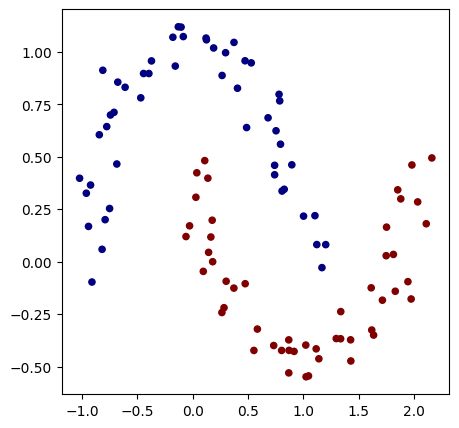

In [2]:
# make up a dataset
np.random.seed(1337)
random.seed(1337)

from sklearn.datasets import make_moons
x_np, y_np = make_moons(n_samples=100, noise=0.1)

y_np = y_np*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(x_np[:,0], x_np[:,1], c=y_np, s=20, cmap='jet')

In [3]:
# Converting data to simplegrad tensors + reshaping to stack data in the batch dimension.
X = Parameter(Tensor(x_np.reshape(100, 2, 1)), _op='xb')
Y = Parameter(Tensor(y_np.reshape(100, 1, 1)), _op='yb')
print(f'X.shape: {X.shape}, Y.shape: {Y.shape}')
print(X.data.data[:1], Y.data.data[:1])

X.shape: (100, 2, 1), Y.shape: (100, 1, 1)
[[[1.12211461]
  [0.08147717]]] [[[-1]]]


In [4]:
# Visualization functions.

def calculate_decision_intensity(model, h=0.25):
    X_data = X.data.data
    x_min, x_max = X_data[:, 0].min() - 1, X_data[:, 0].max() + 1
    y_min, y_max = X_data[:, 1].min() - 1, X_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Xmesh = Parameter(Tensor(np.expand_dims(np.c_[xx.ravel(), yy.ravel()], axis=-1)), _op='xmesh')

    scores = model(Xmesh)
    # Use raw scores instead of thresholding
    Z = scores.data.data[:, 0, 0]
    Z = Z.reshape(xx.shape)
    
    return xx, yy, Z

def visualize_decision_intensity(xx, yy, Z):
    fig = plt.figure()
    # Use a diverging colormap to show positive/negative values
    contour_plot = plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 20), 
                               cmap='RdBu_r', alpha=0.8)
    
    # Add a single contour line at Z=0 to show the decision boundary
    plt.contour(xx, yy, Z, levels=[0], colors='k', linestyles='--', alpha=0.5)
    
    plt.colorbar(contour_plot, label='Model Output')
    plt.scatter(X.data.data[:, 0], X.data.data[:, 1], c=y_np, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

def plot_decision_intensity(model, h=0.25):
    xx, yy, Z = calculate_decision_intensity(model, h)
    visualize_decision_intensity(xx, yy, Z)

Linear layer 2 -> 16, activation: relu, dropout: 0 no init
Linear layer 16 -> 16, activation: relu, dropout: 0 no init
Linear layer 16 -> 1, activation: None, dropout: 0 no init
Sequential(
   Linear(2 -> 16, activation=relu),
   Linear(16 -> 16, activation=relu),
   Linear(16 -> 1, activation=None)
)
initial accuracy: 24%


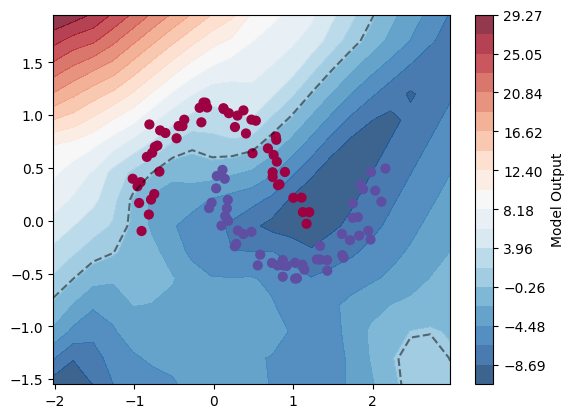

In [5]:
np.random.seed(3)
random.seed(3)
sizes = [2, 16, 16, 1]
model = Sequential([
    Linear(in_size, out_size, activation='relu' if i != len(sizes)-2 else None, no_init=True) 
            for i, (in_size, out_size) in enumerate(zip(sizes[:-1], sizes[1:]))])
print(model)
print(f'initial accuracy: {sum(((Y.data.data > 0) == (model(X).data.data > 0))[:, 0, 0])}%')
plot_decision_intensity(model)

In [6]:
all_boundaries = [calculate_decision_intensity(model)]

## optimization
base_lr = 0.2
lambda_reg = 3e-4
lr_decay_factor = 0.9

iters = 80
for k in range(iters):
    preds = model(X)

    # svm "max-margin" loss
    svm_loss = (1 - Y*preds).relu().sum() / preds.shape[0]

    model.zero_grad()
    svm_loss.backward()
    
    # update (sgd)
    learning_rate = base_lr * (1-lr_decay_factor*k/iters)
    for p in model.parameters():
        if p.grad is not None:
            p.data -= learning_rate * p.grad.sum(dim=0)

    # Metrics
    all_boundaries.append(calculate_decision_intensity(model))
    acc = sum(((Y.data.data > 0) == (preds.data.data > 0))[:, 0, 0])
    weight_sizes = [round(x.data.mean().data.item(), 5) for x in [p*p for p in model.parameters()]]
    if k % 10 == 0:
        print(f"step {k} loss {svm_loss.data.data.item():.7f}, accuracy {acc}%, learning_rate: {learning_rate:.4f}")

step 0 loss 4.9856810, accuracy 24%, learning_rate: 0.2000
step 10 loss 0.3286517, accuracy 87%, learning_rate: 0.1775
step 20 loss 0.2084469, accuracy 90%, learning_rate: 0.1550
step 30 loss 0.0870446, accuracy 97%, learning_rate: 0.1325
step 40 loss 0.0501037, accuracy 99%, learning_rate: 0.1100
step 50 loss 0.0340852, accuracy 99%, learning_rate: 0.0875
step 60 loss 0.0284841, accuracy 100%, learning_rate: 0.0650
step 70 loss 0.0220497, accuracy 100%, learning_rate: 0.0425


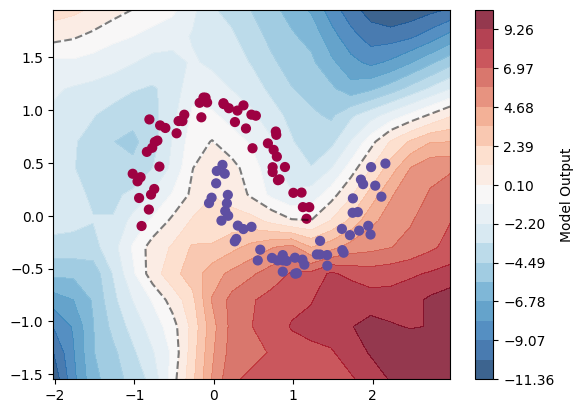

In [7]:
plot_decision_intensity(model)

In [8]:
from matplotlib.animation import FuncAnimation, PillowWriter  # Changed from FFMpegWriter
fig = plt.figure(figsize=(8, 8))
ax = plt.gca()

boundaries = all_boundaries[:75]

# Create initial plot to set up colorbar once
xx, yy, Z = boundaries[0]
contour_plot = ax.contourf(xx, yy, Z, 
                          levels=np.linspace(Z.min(), Z.max(), 20),
                          cmap='RdBu_r', alpha=0.8)
plt.colorbar(contour_plot, label='Model Output')

def animate(i):
    ax.clear()
    xx, yy, Z = boundaries[i]
    
    # Use the same contourf settings as visualize_decision_intensity
    contour_plot = ax.contourf(xx, yy, Z, 
                              levels=np.linspace(Z.min(), Z.max(), 20),
                              cmap='RdBu_r', alpha=0.8)
    
    # Add decision boundary line
    ax.contour(xx, yy, Z, levels=[0], colors='k', linestyles='--', alpha=0.5)
    
    ax.scatter(X.data.data[:, 0], X.data.data[:, 1], c=y_np, s=40, cmap=plt.cm.Spectral)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(f'Iteration {i}')

anim = FuncAnimation(fig, animate, frames=len(boundaries),
                    interval=400,
                    repeat=False)

writer = PillowWriter(fps=5)
anim.save('../assets/decision_boundary.gif', writer=writer)
plt.close()

In [9]:
from IPython.display import HTML
display(HTML(anim.to_jshtml()))